<img src="https://hilpisch.com/tpq_logo_bic.png"
     width="30%"
     align="right"
     style="border-radius: 8px;">

# Derivatives Analytics with Python
**&mdash;Part I: The Market**

&copy; Dr. Yves J. Hilpisch | The Python Quants

<a href="https://tpq.io" target="_blank">tpq.io</a> | <a href="https://linktr.ee/dyjh" target="_blank">linktr.ee/dyjh</a>

<img src="https://hilpisch.com/dawp_cover_small.png" width=30% align=left>

## Part I &mdash; The Market

This notebook introduces market-based valuation as a practical workflow and it summarizes
stylized empirical facts that guide model selection in derivatives analytics.

The notebook is designed to run smoothly on Google Colab. A local setup is optional and
can be based on `python -m venv .venv`.

<small>Note: placing virtual environments inside a synced system folder can inflate cloud
storage and Git repositories with unnecessary files.</small>

### 1. Environment check

We start by importing the core libraries for this class and by printing version
information to confirm that a modern Python environment is active.

In [1]:
import sys  # access basic runtime information
from pathlib import Path  # path handling for optional figure export

import math  # elementary math functions

import numpy as np  # numerical arrays and linear algebra tools
import pandas as pd  # tabular data handling
import matplotlib as mpl  # matplotlib configuration
import matplotlib.pyplot as plt  # plotting

np.set_printoptions(precision=6, suppress=True)  # compact numeric output

print(sys.version.split()[0])  # Python version string
print("NumPy:", np.__version__)  # NumPy version string

FIG_SAVE = True  # set to True to export figures as PDFs
FIG_DIR = Path("../figures")  # figure output directory
FIG_DPI = 300  # target resolution for exported figures
FIG_DISPLAY = "svg"  # inline display format: "svg" or "png"

plt.style.use("seaborn-v0_8")  # readable plotting defaults
mpl.rcParams["figure.figsize"] = (8.0, 4.5)  # consistent figure size
mpl.rcParams["axes.grid"] = True  # show a grid for readability
mpl.rcParams["savefig.dpi"] = FIG_DPI  # default export resolution

try:
    from matplotlib_inline.backend_inline import (  # Jupyter helper
        set_matplotlib_formats,
    )
    set_matplotlib_formats(FIG_DISPLAY)  # configure inline plot rendering
except Exception:
    pass

if FIG_DISPLAY == "png":
    mpl.rcParams["figure.dpi"] = FIG_DPI  # high-resolution inline rendering


def maybe_save(fig, filename):
    # Optionally saves a Matplotlib figure as a PDF file.
    if not FIG_SAVE:
        return
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    path = FIG_DIR / f"{filename}.pdf"
    fig.savefig(path, format="pdf", dpi=FIG_DPI)
    print(f"saved: {path}")

3.11.13
NumPy: 2.3.5


### 2. European call option payoff

A European call option has payoff `max(S_T - K, 0)` at maturity. We first implement
the payoff as a vector operation and then visualize the payoff curve.

In [2]:
K = 8000.0  # strike level
S_T = np.array([7800.0, 8000.0, 8200.0])  # terminal index levels
h_T = np.maximum(S_T - K, 0.0)  # call payoff at maturity

print(h_T)  # payoff vector for the three scenarios

[  0.   0. 200.]


saved: ../figures/dawp_pI_fig01_inner_value.pdf


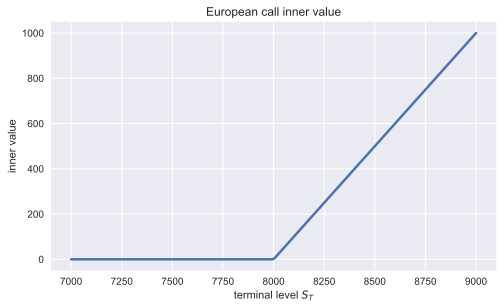

In [3]:
S = np.linspace(7000.0, 9000.0, 200)  # terminal levels for plotting
h = np.maximum(S - K, 0.0)  # inner values on the grid

fig, ax = plt.subplots()  # create a single plot
ax.plot(S, h, lw=2.5)  # plot call inner value
ax.set_xlabel(r"terminal level $S_T$")  # x-axis label
ax.set_ylabel("inner value")  # y-axis label
ax.set_title("European call inner value")  # plot title

maybe_save(fig, "dawp_pI_fig01_inner_value")  # optional PDF export
plt.show()  # display the plot

### 3. Time value and a benchmark present value curve

A benchmark valuation uses the Black--Scholes--Merton formula for a European call
option and illustrates how a present value curve differs from the inner value.

In [4]:
def norm_cdf(x):
    # Standard normal cumulative distribution function via the error function.
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


def bsm_call_value(S0, K, T, r, sigma):
    # Black--Scholes--Merton call option value for non-dividend paying underlyings.
    if T <= 0.0:
        return max(S0 - K, 0.0)
    if sigma <= 0.0:
        return math.exp(-r * T) * max(S0 - K, 0.0)
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S0 * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)

saved: ../figures/dawp_pI_fig02_bsm_vs_inner.pdf


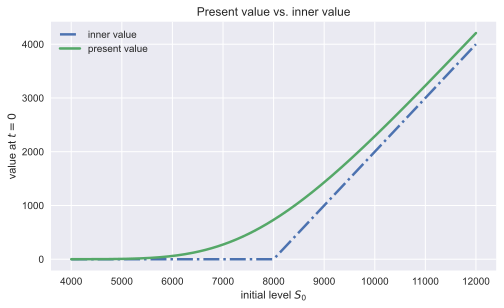

In [5]:
T = 1.0  # time to maturity in years
r = 0.025  # constant short rate
sigma = 0.20  # annual volatility

S0_grid = np.linspace(4000.0, 12000.0, 200)  # initial levels for plotting
inner = np.maximum(S0_grid - K, 0.0)  # inner value proxy on the grid
C0 = np.array([bsm_call_value(x, K, T, r, sigma) for x in S0_grid])
  # BSM present values on the grid

fig, ax = plt.subplots()  # create a single plot
ax.plot(S0_grid, inner, ls='-.', lw=2.5, label='inner value')  # inner value
ax.plot(S0_grid, C0, lw=2.5, label='present value')  # BSM value
ax.set_xlabel(r"initial level $S_0$")  # x-axis label
ax.set_ylabel(r"value at $t=0$")  # y-axis label
ax.legend(loc=0)  # place the legend
ax.set_title("Present value vs. inner value")  # plot title

maybe_save(fig, "dawp_pI_fig02_bsm_vs_inner")  # optional PDF export
plt.show()  # display the plot

### 4. Normal returns as a benchmark (GBM)

A canonical benchmark for equity prices is geometric Brownian motion (GBM), which implies
normally distributed log-returns. We simulate a GBM series that matches the length and the
DatetimeIndex of the real SPY data and use it as a reference point.

In [6]:
from numpy.random import default_rng  # random number generator

DATA_URL = "https://hilpisch.com/nov25eod.csv"  # EOD data source
raw = pd.read_csv(DATA_URL)  # load data from the URL

possible_dates = {"date", "datetime", "timestamp"}  # date column candidates

date_col = None  # date column name
for col in raw.columns:
    if col.lower() in possible_dates:
        date_col = col  # store the date column name
        break

if date_col is None:
    raise ValueError("No date column found in the data.")  # fail early

raw[date_col] = pd.to_datetime(raw[date_col])  # parse dates
raw = raw.sort_values(date_col)  # sort by time

cols_lower = {c.lower(): c for c in raw.columns}  # lower-case lookup
sym_col = cols_lower.get("symbol") or cols_lower.get("ticker")  # symbol column

price_candidates = [
    "adj_close",
    "adjclose",
    "adj close",
    "close",
    "price",
]  # price column candidates

price_col = None  # price column name
for key in price_candidates:
    if key in cols_lower:
        price_col = cols_lower[key]  # store the price column name
        break

if sym_col and price_col:
    prices = raw.pivot(index=date_col, columns=sym_col, values=price_col)
      # pivot to wide format: dates x tickers
else:
    prices = raw.set_index(date_col)  # assume already wide

prices = prices.sort_index()  # enforce chronological order

spy = prices["SPY"].dropna()  # SPY close series
r_spy = np.log(spy / spy.shift(1)).dropna()  # SPY log-returns

rng = default_rng(42)  # fixed seed for reproducibility

mu_hat = float(r_spy.mean())  # sample mean of daily log-returns
sig_hat = float(r_spy.std(ddof=1))  # sample volatility of daily log-returns

r_gbm = rng.normal(mu_hat, sig_hat, size=len(r_spy))  # Gaussian benchmark returns

S0 = float(spy.loc[r_spy.index[0]])
  # align the initial level to the first return date
S_gbm = S0 * np.exp(np.cumsum(r_gbm))  # GBM benchmark level series
S_gbm = pd.Series(S_gbm, index=r_spy.index, name="GBM")  # attach the DatetimeIndex

print("range:", spy.index.min().date(), "to", spy.index.max().date())
print("SPY obs:", len(spy), "returns:", len(r_spy))  # series lengths


range: 2015-11-30 to 2025-11-28
SPY obs: 2515 returns: 2514


saved: ../figures/dawp_pI_fig03a_gbm_path_returns.pdf


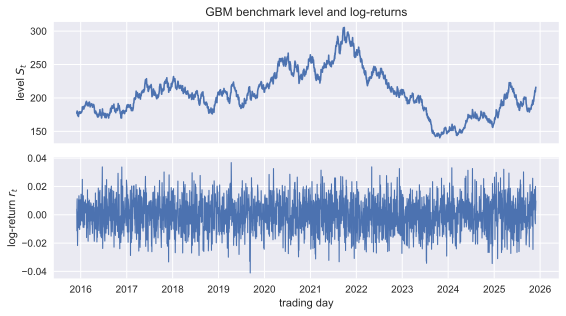

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)  # two-row figure

ax1.plot(S_gbm, lw=1.6)  # plot the GBM level
ax1.set_ylabel(r"level $S_t$")  # y-axis label
ax1.set_title("GBM benchmark level and log-returns")  # title

r_gbm_s = pd.Series(r_gbm, index=S_gbm.index)  # align returns to the dates
ax2.plot(r_gbm_s, lw=1.1)  # plot daily log-returns
ax2.set_ylabel(r"log-return $r_t$")  # y-axis label
ax2.set_xlabel("trading day")  # x-axis label

fig.tight_layout()  # improve spacing
maybe_save(fig, "dawp_pI_fig03a_gbm_path_returns")  # optional PDF export
plt.show()  # display the figure

saved: ../figures/dawp_pI_fig04a_gbm_qqplot.pdf


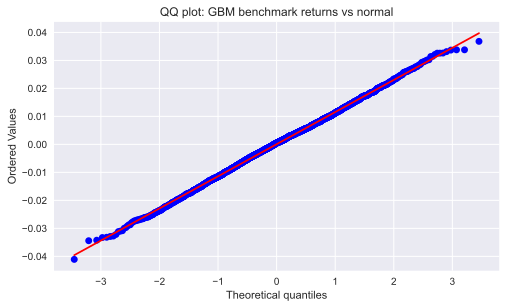

In [8]:
try:
    from scipy import stats  # statistical utilities
except Exception as e:
    stats = None  # fallback if SciPy is unavailable
    print(e)  # show the import error

if stats is not None:
    fig, ax = plt.subplots()  # create a single plot
    stats.probplot(r_gbm, dist="norm", plot=ax)  # QQ plot vs normal
    ax.set_title("QQ plot: GBM benchmark returns vs normal")  # title
else:
    fig, ax = plt.subplots()  # create a single plot
    ax.hist(r_gbm, bins=60, density=True, alpha=0.65)  # return histogram

    x = np.linspace(mu_hat - 4.0 * sig_hat, mu_hat + 4.0 * sig_hat, 400)
      # evaluation grid for the normal PDF
    num = np.exp(-0.5 * ((x - mu_hat) / sig_hat) ** 2)
      # numerator of the fitted normal PDF
    den = sig_hat * np.sqrt(2.0 * np.pi)  # normalization constant
    pdf = num / den  # fitted normal PDF values

    ax.plot(x, pdf, lw=2.0)  # overlay fitted normal density
    ax.set_title("Histogram: GBM benchmark returns vs normal")  # title

maybe_save(fig, "dawp_pI_fig04a_gbm_qqplot")  # optional PDF export
plt.show()  # display the plot

saved: ../figures/dawp_pI_fig05a_gbm_rolling_vol.pdf


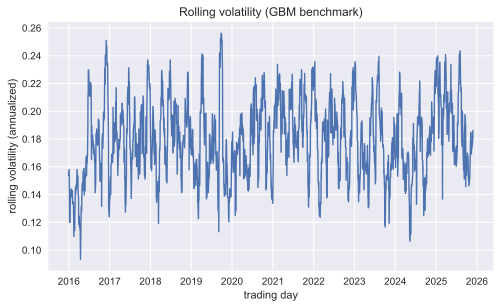

In [9]:
window = 21  # 1-month rolling window (trading days)
roll_vol_gbm = pd.Series(r_gbm, index=r_spy.index).rolling(window).std(ddof=1)
roll_vol_gbm = roll_vol_gbm * np.sqrt(252.0)  # annualized rolling volatility

fig, ax = plt.subplots()  # create a single plot
ax.plot(roll_vol_gbm, lw=1.4)  # plot rolling volatility
ax.set_xlabel("trading day")  # x-axis label
ax.set_ylabel("rolling volatility (annualized)")  # y-axis label
ax.set_title("Rolling volatility (GBM benchmark)")  # plot title

maybe_save(fig, "dawp_pI_fig05a_gbm_rolling_vol")  # optional PDF export
plt.show()  # display the plot

### 5. Stylized facts with real market data

With the benchmark in place, we turn to the real SPY series and compare it to the normal
benchmark. Even when the benchmark matches mean and volatility, real returns typically
exhibit heavy tails, asymmetry, and volatility clustering.

Source: https://hilpisch.com/nov25eod.csv

saved: ../figures/dawp_pI_fig03_spy_path_returns.pdf


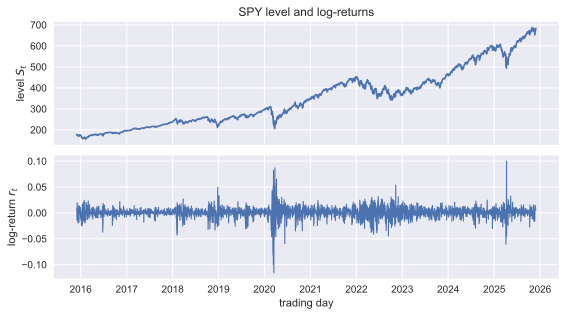

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)  # two-row figure

ax1.plot(spy.loc[r_spy.index], lw=1.6)  # plot the SPY level
ax1.set_ylabel(r"level $S_t$")  # y-axis label
ax1.set_title("SPY level and log-returns")  # title

ax2.plot(r_spy, lw=1.1)  # plot daily log-returns
ax2.set_ylabel(r"log-return $r_t$")  # y-axis label
ax2.set_xlabel("trading day")  # x-axis label

fig.tight_layout()  # improve spacing
maybe_save(fig, "dawp_pI_fig03_spy_path_returns")  # optional PDF export
plt.show()  # display the figure

saved: ../figures/dawp_pI_fig04_spy_qqplot.pdf


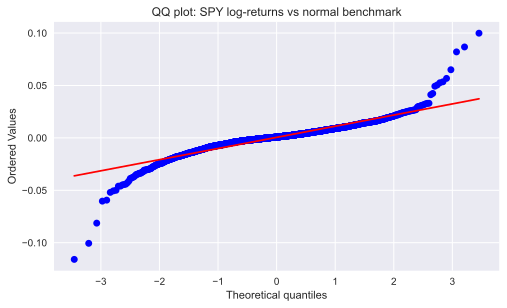

In [11]:
try:
    from scipy import stats  # statistical utilities
except Exception as e:
    stats = None  # fallback if SciPy is unavailable
    print(e)  # show the import error

if stats is not None:
    fig, ax = plt.subplots()  # create a single plot
    stats.probplot(r_spy.values, dist="norm", plot=ax)  # QQ plot vs normal
    ax.set_title("QQ plot: SPY log-returns vs normal benchmark")  # title
else:
    fig, ax = plt.subplots()  # create a single plot
    ax.hist(r_spy, bins=60, density=True, alpha=0.65)  # return histogram

    x = np.linspace(mu_hat - 4.0 * sig_hat, mu_hat + 4.0 * sig_hat, 400)
      # evaluation grid for the normal PDF
    num = np.exp(-0.5 * ((x - mu_hat) / sig_hat) ** 2)
      # numerator of the fitted normal PDF
    den = sig_hat * np.sqrt(2.0 * np.pi)  # normalization constant
    pdf = num / den  # fitted normal PDF values

    ax.plot(x, pdf, lw=2.0)  # overlay fitted normal density
    ax.set_title("Histogram: SPY log-returns vs normal benchmark")  # title

maybe_save(fig, "dawp_pI_fig04_spy_qqplot")  # optional PDF export
plt.show()  # display the plot

saved: ../figures/dawp_pI_fig05_spy_rolling_vol.pdf


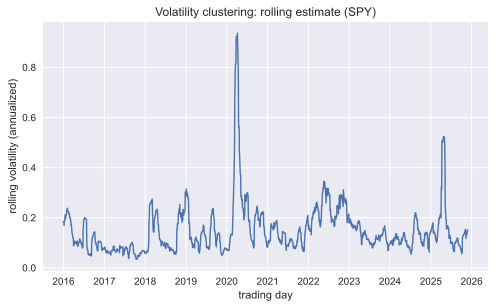

In [12]:
window = 21  # 1-month rolling window (trading days)
roll_vol = r_spy.rolling(window).std(ddof=1) * np.sqrt(252.0)
  # annualized rolling volatility

fig, ax = plt.subplots()  # create a single plot
ax.plot(roll_vol, lw=1.4)  # plot rolling volatility
ax.set_xlabel("trading day")  # x-axis label
ax.set_ylabel("rolling volatility (annualized)")  # y-axis label
ax.set_title("Volatility clustering: rolling estimate (SPY)")  # plot title

maybe_save(fig, "dawp_pI_fig05_spy_rolling_vol")  # optional PDF export
plt.show()  # display the plot

### 6. A stylized implied volatility surface

Implied volatility varies with strike and maturity. A synthetic surface is useful for
illustrating the qualitative shape (smile/skew and term structure).

saved: ../figures/dawp_pI_fig06_iv_surface.pdf


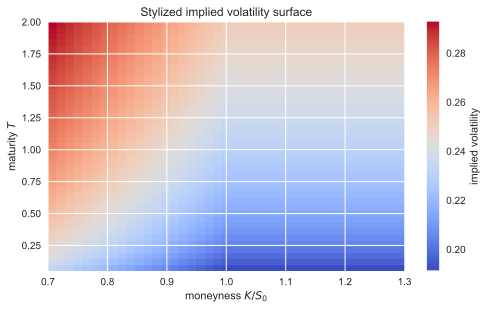

In [13]:
K_grid = np.linspace(0.7, 1.3, 41)  # moneyness grid K/S0
T_grid = np.linspace(0.05, 2.0, 41)  # maturity grid in years
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)  # grid for surface

base = 0.18  # base volatility level
skew = 0.14  # left-skew intensity
term = 0.05  # term structure slope

iv = base + skew * np.maximum(1.0 - K_mesh, 0.0) + term * np.sqrt(T_mesh)
  # stylized implied volatility surface

fig, ax = plt.subplots()  # create a single plot
im = ax.imshow(
    iv,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    extent=[K_grid.min(), K_grid.max(), T_grid.min(), T_grid.max()],
)
ax.set_xlabel(r"moneyness $K/S_0$")  # x-axis label
ax.set_ylabel(r"maturity $T$")  # y-axis label
ax.set_title("Stylized implied volatility surface")  # plot title
cbar = fig.colorbar(im, ax=ax)  # add a color bar
cbar.set_label("implied volatility")  # label the color bar

maybe_save(fig, "dawp_pI_fig06_iv_surface")  # optional PDF export
plt.show()  # display the plot

### 7. Rates proxy from `TLT`

Short rates require a dedicated money-market series. As a compact proxy for rate movements,
we use the Treasury bond ETF `TLT` and translate price changes into yield changes via a
simple duration approximation.

saved: ../figures/dawp_pI_fig07_tlt_yield_proxy.pdf


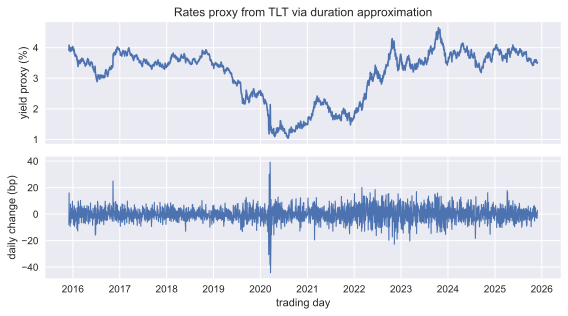

In [14]:
tlt = prices["TLT"].dropna()  # TLT close series

D_TLT = 17.0  # duration proxy for TLT (rough, but serviceable)

dy = -(tlt.pct_change().dropna()) / D_TLT
  # yield change proxy from bond price changes

y0 = 0.04  # baseline yield level for the proxy

y_proxy = y0 + dy.cumsum()  # integrate yield changes into a yield series

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)  # two-row figure

ax1.plot(100.0 * y_proxy, lw=1.6)  # plot the yield proxy
ax1.set_ylabel("yield proxy (%)")  # y-axis label
ax1.set_title("Rates proxy from TLT via duration approximation")  # title

ax2.plot(1e4 * dy, lw=1.1)  # plot daily yield changes
ax2.set_ylabel("daily change (bp)")  # y-axis label
ax2.set_xlabel("trading day")  # x-axis label

fig.tight_layout()  # improve spacing
maybe_save(fig, "dawp_pI_fig07_tlt_yield_proxy")  # optional PDF export
plt.show()  # display the figure

<img src="https://hilpisch.com/tpq_logo_bic.png"
     width="30%"
     align="right"
     style="border-radius: 8px;">